## Analysis code of denosing effect for peak detection with ground truth

In [1]:
import numpy as np

import pandas as pd
import matplotlib.ticker as ptick

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sns.set_palette("cividis")
import scipy.io
import scipy.ndimage as ndimage
from scipy import signal
from sklearn.metrics import mean_squared_error

from tqdm import tqdm
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from scipy.stats import gaussian_kde

In [2]:
def featureplot(data,x_name,y_name,hue="Name",):
    
    g= sns.JointGrid(data=data[(data[x_name]>0)&(data[y_name]>0)],x=x_name,y=y_name,hue=hue,height=10,ylim=(1e-4,1),xlim=(1e-4,1))
    g.plot_joint(sns.scatterplot, s=9, alpha=.5,palette="tab10")
    g.plot_marginals(sns.histplot,fill=True,alpha=.5,palette="tab10",binwidth=0.1, kde=True,log_scale=True)
    g.ax_marg_x.set_xscale('log')
    g.ax_marg_y.set_yscale('log')
    sns.despine()

def positive_trigger(raw,unit=100,trigger_th=0.1,pre_tig=20,ch=2):
    raw=np.array(raw)
    i=pre_tig
    
    pos, _ =signal.find_peaks(raw[pre_tig:-1*unit,ch],height=trigger_th,distance=20)
    pos=pos[pos>pre_tig]
    data=np.zeros((len(pos),unit,4))
    for i in range(len(pos)):
        data[i]=raw[pos[i]-pre_tig:pos[i]-pre_tig+unit]
    
    return data
def load_dataset(at,t_max):
    file_path=f"../results"
    temp=np.load(file_path+"/median.npy").flatten()
    wv=np.zeros((len(temp),3))
    nl=["attenuated", "median", "ground_truth"]
    for i in range(3):
        wv[:,i]=np.load(file_path+f"/{nl[i]}.npy").flatten()
        wv[:,i]=wv[:,i]-np.mean(wv[:100,i])
        wv[:,i]=wv[:,i]/np.max(wv[:,i])

    wv[:,-1]= np.roll(wv[:,-1], -3) #shift_compasation
    wv=wv[:t_max]
    wv_temp=np.zeros((len(wv),4))
    wv_temp[:,0]=wv[:,0] #at
    wv_temp[:,2]=wv[:,1] #denoise
    wv_temp[:,1]=ndimage.gaussian_filter1d(wv[:,0],3)
    wv_temp[:,3]=wv[:,2] #gt

    return wv_temp

def mmse(wv1,wv2):
    wv1=wv1/wv1.max()
    wv2=wv2/wv2.max()
    return mean_squared_error(wv1,wv2)

def PSNR(wv1,wv2):
    wv1=wv1/wv1.max()
    wv2=wv2/wv2.max()
    mmse_cal=mmse(wv1,wv2)
    PSNR_cal=10*np.log10(wv1.max()**2/mmse_cal)
    return PSNR_cal

def matching_label(x_1,x_2,width=10): #true positive, false positive, false negative classifcation using GT peaks
    tp_1=[]
    tp_2=[]

    for i in range(len(x_2)):
        temp=abs(x_1-x_2[i])
        if np.min(temp)<=20:
            x_2_to_1=x_1[np.argmin(temp)]
            x_1_to_2=x_2[np.argmin(abs(x_2-x_2_to_1))]
            if x_1_to_2==x_2[i]:
                tp_1.append(x_2[i])
                tp_2.append(x_2_to_1)
    tp_1=np.array(tp_1)
    tp_2=np.array(tp_2)
    fn=np.setdiff1d(x_1 ,tp_2)
    fp=np.setdiff1d(x_2 ,tp_1)
    return tp_1,fp,fn 
    
    
    
    
    

## Dataloder (4ch=before denosing,after denosing, gaussian filter, ground truth)

In [3]:
#sns.set_context("poster")
t_max=500000*4
fl=["2.2"]
wv=load_dataset(fl[0],t_max=t_max)



            

# Histgram calculation

In [4]:

gt,_=signal.find_peaks(wv[:t_max,-1]/wv[:t_max,-1].max(),height=0.1,distance=50)

at,_=signal.find_peaks(wv[:t_max,0]/wv[:t_max,0].max(),height=0.2,distance=50)
tp,fp,fn=matching_label(gt,at) # nar

In [5]:
df=pd.DataFrame()
nl=["Attenuated", "Denosied" ,"Gaussian","Ground truth"]
for i in range(len(nl)):
    df[nl[i]+" scattering heigt[V]"]= np.concatenate([wv[tp,i],wv[fn,i],wv[fp,i]])
df["Label"]= np.concatenate([[ "Signal" for i in range(len(tp)+len(fn))],[ "Noise" for i in range(len(fp))]])
d1=positive_trigger(wv,trigger_th=np.max(wv[:,-1]*0.01),unit=200,pre_tig=30)

## Waveform and histgram plot

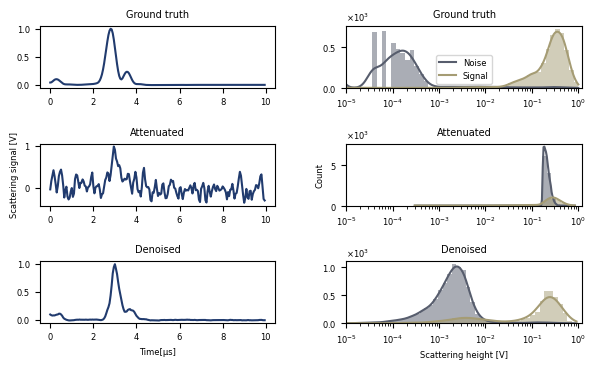

In [6]:
figure = plt.figure(figsize=(7,7))
plt.rcParams["font.family"] = "Arial"  
plt.rcParams["font.size"] = 6
gs_master = GridSpec(nrows=4, ncols=2, height_ratios=[1, 1, 1,3],wspace=0.3, hspace=0.6)
c_l=["mediumpurple","darkcyan","indigo"]
nl = ["Attenuated", "Gaussian","Denoised","Ground truth"]
cn = [3, 0, 2]
sns.set_palette("cividis")
for i in range(3):
    gs_1 = GridSpecFromSubplotSpec(nrows=1, ncols=1, subplot_spec=gs_master[0+i, 0])
    axes_1 = figure.add_subplot(gs_1[:, :])
    axes_1.set_title(nl[cn[i]],fontsize=7)
    n=2
    axes_1.plot(np.arange(200)/20,d1[n,:,cn[i]]/d1[n,:,cn[i]].max(),label=nl[cn[i]])
    
    if i ==1:
        axes_1.set_ylabel("Scattering signal [V]")
    if i ==2:
        axes_1.set_xlabel("Time[μs]")
    
    #axes_1.legend(loc="upper right")
    
for i in range(3):
    gs_1 = GridSpecFromSubplotSpec(nrows=1, ncols=1, subplot_spec=gs_master[0+i, 1])
    axes_1 = figure.add_subplot(gs_1[:, :])
    axes_1.set_title(nl[cn[i]],fontsize=7)

    sns.histplot(data=df,x=df.columns[cn[i]],hue=df.columns[-1],log_scale=True,binwidth=0.1,lw=0,ax=axes_1,palette="cividis_r",legend=False,kde=True)
    axes_1.set_xlabel("")
    axes_1.set_xlabel("")
    axes_1.set_ylabel("")
    axes_1.yaxis.set_major_formatter(ptick.ScalarFormatter(useMathText=True)) 
    axes_1.ticklabel_format(style="sci", axis="y", scilimits=(3,3))
    axes_1.set_xlim(1e-5,1.2)
    if i ==0:
        axes_1.legend(["Noise","Signal"])
    if i ==1:
        axes_1.set_ylabel("Count")
    if i ==2:
        axes_1.set_xlabel("Scattering height [V]")
        



## Precision& recall calculation

In [7]:
SNR_L= np.arange(1000)/1000-0.001
x_n=50000*4
recall_list=np.zeros((len(SNR_L),4))
precision_list=np.zeros((len(SNR_L),4))
gt,_=signal.find_peaks(wv[:x_n,-1]/wv[:x_n,-1].max(),height=0.1,distance=20)
for i in tqdm(range(len(SNR_L))):
    for j in range(4):
        at,_=signal.find_peaks(wv[:x_n,j]/wv[:x_n,j].max(),height=SNR_L[i],distance=20)
        tp,fp,fn=matching_label(gt,at)
        recall_list[i,j]=(len(tp)/(len(tp)+len(fn)))
        precision_list[i,j]=(len(tp)/(len(tp)+len(fp)))

mAP=np.zeros((4))
for j in range(4):
    mAP[j]=np.trapz(x=recall_list[:,j],y=precision_list[:,j])
    

100%|██████████| 1000/1000 [00:19<00:00, 50.56it/s]


## Precision-recall curve plot

Text(0, 0.5, 'Precision')

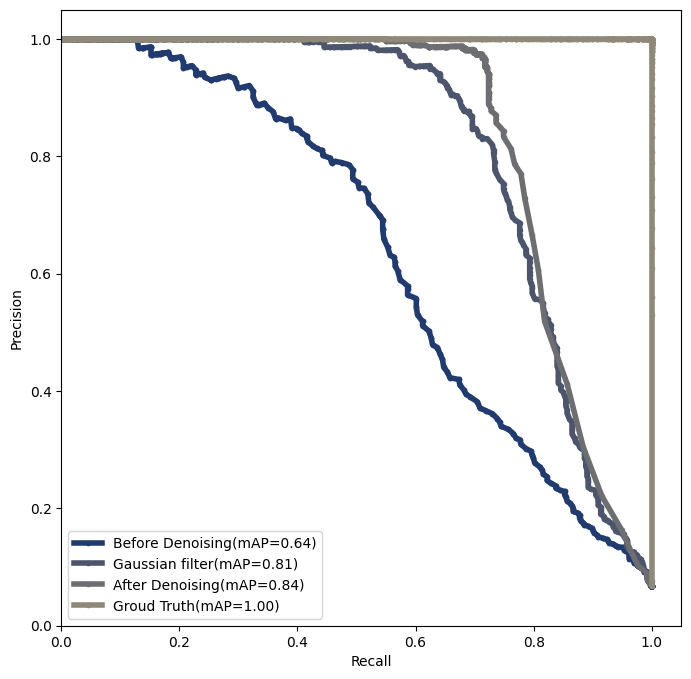

In [8]:
plt.figure(figsize=(8,8))
plt.rcParams["font.family"] = "Arial"  
plt.rcParams["font.size"] = 10


cl=["mediumpurple","lightblue","darkcyan","indigo"]
nl=[f"Before Denoising(mAP={abs(mAP[0]):.2f})",f"Gaussian filter(mAP={abs(mAP[1]):.2f})",f"After Denoising(mAP={abs(mAP[2]):.2f})",f"Groud Truth(mAP={abs(mAP[3]):.2f})"]

#plt.title("Attnuation OD=3.2")
for i in range(4):
    plt.plot(recall_list[:,i],precision_list[:,i],"-o",label=nl[i],lw=4,ms=3)
plt.legend()

#plt.grid()
plt.xlim(0,1.05)
plt.ylim(0,1.05)


plt.xlabel("Recall")
plt.ylabel("Precision")




In [9]:

gt,_=signal.find_peaks(wv[:t_max,-1]/wv[:t_max,-1].max(),height=0.1,distance=50)
at,_=signal.find_peaks(wv[:t_max,0]/wv[:t_max,0].max(),height=0.2,distance=50)

In [10]:
at=at[at>100]
cal=np.zeros((len(at),3))
for i in range(3):
    for j in range(len(at)):
        cal[j,i]=PSNR(wv[at[j]-100:at[j]+100,i],wv[at[j]-100:at[j]+100,-1])

# PSNR_scatter plot

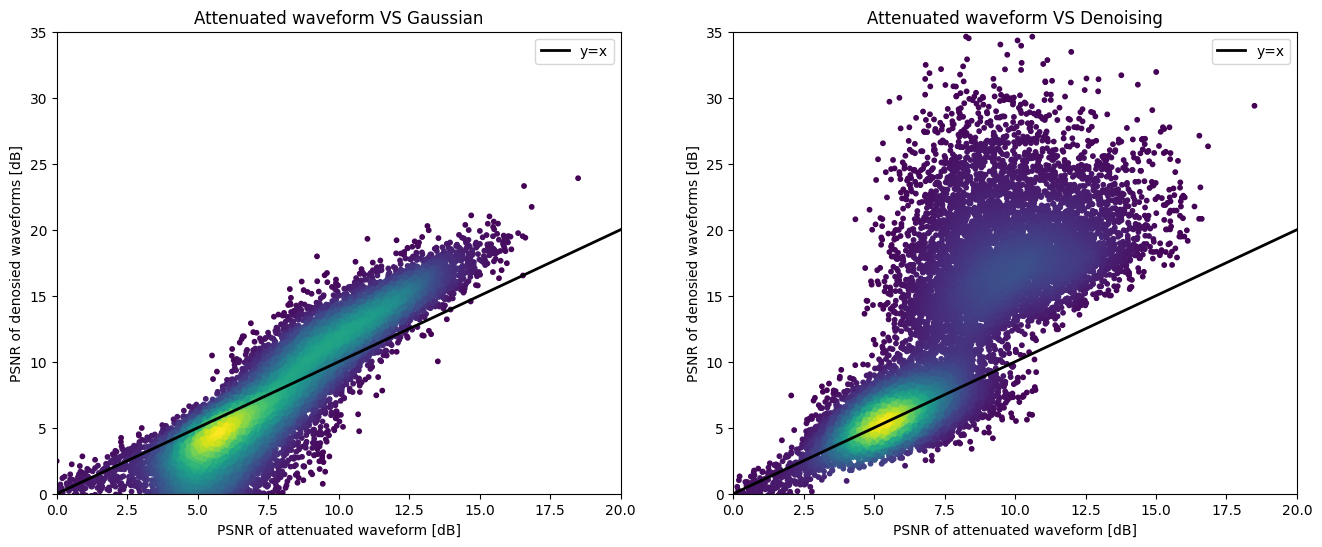

In [11]:

fig = plt.figure(figsize=(16,6))
nl=["Gaussian","Denoising"]
for i in range(2):
    plt.subplot(1,2,1+i)
    plt.title(f"Attenuated waveform VS {nl[i]}")
    x=cal[:,0]
    y=cal[:,i+1]
    xy = np.vstack([x,y]) 
    z = gaussian_kde(xy)(xy)
    idx = z.argsort() 
    x1=np.arange(40)
    plt.plot(x1,x1,"k-",lw=2,label="y=x")
    plt.scatter(x, y, c=z, s=10, cmap="viridis")
    plt.xlabel("PSNR of attenuated waveform [dB]")
    plt.ylabel("PSNR of denosied waveforms [dB]")
    plt.xlim(0,20)
    plt.ylim(0,35)
    plt.legend()
    
plt.show()
